<a href="https://colab.research.google.com/github/chirucodes/aiml/blob/main/automatic_image_captioning/ResNet50_LSTM_with_Attention_ImageCaptioningGroup4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reference Links to follow

In [30]:
# Add reference links below

# https://www.analyticsvidhya.com/blog/2018/04/solving-an-image-captioning-task-using-deep-learning/
# https://rupamgoyal12.medium.com/image-caption-generator-using-resnet50-and-lstm-model-a5b11f60cd23

# 

## Hyper Parameters

In [16]:
HYP_DOWNLOAD_DATASET = True
HYP_MOUNT_GOOGLE = False
HYP_SOURCE_DATA_SET = "F8K" # "F30K" / "COCO123K"
HYP_ENCODER_MODEL = "INCEPTIONV3" #"RESNET50" VGG16, INCEPTIONV3 , etc
HYP_WORD_EMBEDDING = "GLOVE" # word2vec, etc
HYP_ENABLE_TRACE = False # True
HYP_ENABLE_ATTENTION = True # False
HYP_DECODER_LOSS = 'categorical_crossentropy'
HYP_DECODER_OPTIMIZER = 'adam'
HYP_NO_OF_PICS_PER_BATCH = 5
HYP_EPOCH = 2
HYP_DECODER_LEARNING_RATE = 0.0001
HYP_GENERATE_BLEU_SCORE = True
HYP_GENERATE_METEOR_SCORE = True


## Import Modules

In [17]:
# To list file in a directory
import glob


# Image preprocessing / converting image into feature vectors
from keras.preprocessing import image
import numpy as np

if HYP_ENCODER_MODEL == "RESNET50":
    from tensorflow.keras.applications.resnet50 import preprocess_input
    from tensorflow.keras.applications.resnet50 import ResNet50

elif HYP_ENCODER_MODEL == "VGG16":
    from keras.applications.vgg16 import preprocess_input
    from keras.applications.vgg16 import VGG16


elif HYP_ENCODER_MODEL == "INCEPTIONV3":
    from tensorflow.keras.applications.inception_v3 import preprocess_input
    from tensorflow.keras.applications.inception_v3 import InceptionV3

else:
    print("Invalid HYP_ENCODER_MODEL")


from keras.models import Model


# Execution time calculation
from time import time


# Creating binary files
from pickle import dump, load


# Text processing
import string


# For joining os path
import os


# LSTM architecture
from keras import Input
from keras.layers import Dropout, Dense, Embedding, LSTM
from keras.layers.merge import add
from keras.models import Model


# For caption generation
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from numpy import array
import matplotlib.pyplot as plt

from google.colab import drive

#############
from keras.layers import Layer
import keras.backend as K

import keras

from tensorflow.keras.utils import plot_model

# For bleu score
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
if HYP_GENERATE_METEOR_SCORE:
    import nltk
    nltk.download('wordnet')
    nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Download dataset and unzip

In [18]:
if HYP_MOUNT_GOOGLE:
    drive.mount('/content/drive')
    images = glob.glob("/content/drive/MyDrive/AI ML/AIC Project/datasets/Flicker8k/Images")
    images


#### Flicker 8k

In [19]:
if HYP_DOWNLOAD_DATASET:
    if HYP_SOURCE_DATA_SET == "F8K":
        !rm -rf Flickr8k_Dataset.zip
        !rm -rf Flickr8k_text.zip
        !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip -O Flickr8k_Dataset.zip
        !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip -O Flickr8k_text.zip
        !unzip Flickr8k_Dataset.zip
        !unzip Flickr8k_text.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429581486_4556471d1a.jpg  
  inflating: Flicker8k_Dataset/3429641260_2f035c1813.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429641260_2f035c1813.jpg  
  inflating: Flicker8k_Dataset/3429956016_3c7e3096c2.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429956016_3c7e3096c2.jpg  
  inflating: Flicker8k_Dataset/3430100177_5864bf1e73.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430100177_5864bf1e73.jpg  
  inflating: Flicker8k_Dataset/3430287726_94a1825bbf.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430287726_94a1825bbf.jpg  
  inflating: Flicker8k_Dataset/3430526230_234b3550f6.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430

#### Flicker 30k

In [20]:
if HYP_SOURCE_DATA_SET == "F30K":
    !rm -rf Flickr8k_Dataset.zip
    !rm -rf Flickr8k_text.zip
    !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip -O Flickr8k_Dataset.zip
    !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip -O Flickr8k_text.zip
    !unzip Flickr8k_Dataset.zip
    !unzip Flickr8k_text.zip

#### Coco 

In [21]:
if HYP_SOURCE_DATA_SET == "COCO123K":
    !rm -rf Flickr8k_Dataset.zip
    !rm -rf Flickr8k_text.zip
    !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip -O Flickr8k_Dataset.zip
    !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip -O Flickr8k_text.zip
    !unzip Flickr8k_Dataset.zip
    !unzip Flickr8k_text.zip

## Extract Features

#### Image feature extractor


###### Defining source variables and initialise **train and test images list**

In [22]:
if HYP_SOURCE_DATA_SET == "F8K":
    # Below path contains all the images
    images = '/content/Flicker8k_Dataset/'

    # Below file conatains the names of images to be used in train data
    train_images_file = '/content/Flickr_8k.trainImages.txt'

    # Below file conatains the names of images to be used in test data
    test_images_file = '/content/Flickr_8k.testImages.txt'

elif HYP_SOURCE_DATA_SET == "F30K":
    # Below path contains all the images
    images = ''

    # Below file conatains the names of images to be used in train data
    train_images_file = ''

    # Below file conatains the names of images to be used in test data
    test_images_file = ''

elif HYP_SOURCE_DATA_SET == "COCO123K":
    # Below path contains all the images
    images = ''

    # Below file conatains the names of images to be used in train data
    train_images_file = ''

    # Below file conatains the names of images to be used in test data
    test_images_file = ''

else:
    print("Invalid HYP_SOURCE_DATA_SET")

In [23]:
# Train + Test
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [24]:
type(img), img[:5]

(list,
 ['/content/Flicker8k_Dataset/1463732130_a754441289.jpg',
  '/content/Flicker8k_Dataset/3628017876_4ac27e687b.jpg',
  '/content/Flicker8k_Dataset/224702242_a62aaa6dff.jpg',
  '/content/Flicker8k_Dataset/1731546544_9fbf14617b.jpg',
  '/content/Flicker8k_Dataset/3149804151_1cc8d10783.jpg'])

In [25]:
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
type(train_images), len(train_images), list(train_images)[:5]

(set,
 6000,
 ['1235580648_7eebaed9bc.jpg',
  '3412036192_d8cd12ed3f.jpg',
  '2355819665_39021ff642.jpg',
  '3080891382_edf83dde18.jpg',
  '3467282545_273a97b628.jpg'])

In [26]:
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

type(test_images), len(test_images), list(test_images)[:5]

(set,
 1000,
 ['1056338697_4f7d7ce270.jpg',
  '3138399980_d6ab8b2272.jpg',
  '1626754053_81126b67b6.jpg',
  '3582742297_1daa29968e.jpg',
  '2631300484_be8621d17b.jpg'])

In [27]:
images

'/content/Flicker8k_Dataset/'

In [28]:
# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

type(train_img), len(train_img), train_img[:5]

(list,
 6000,
 ['/content/Flicker8k_Dataset/1463732130_a754441289.jpg',
  '/content/Flicker8k_Dataset/3628017876_4ac27e687b.jpg',
  '/content/Flicker8k_Dataset/224702242_a62aaa6dff.jpg',
  '/content/Flicker8k_Dataset/3225296260_2ee72b4917.jpg',
  '/content/Flicker8k_Dataset/2407470303_6fd5e3600d.jpg'])

In [29]:
# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

type(test_img), len(test_img), test_img[:5]

(list,
 1000,
 ['/content/Flicker8k_Dataset/3696698390_989f1488e7.jpg',
  '/content/Flicker8k_Dataset/3244470342_c08f6bb17e.jpg',
  '/content/Flicker8k_Dataset/533979933_a95b03323b.jpg',
  '/content/Flicker8k_Dataset/3613424631_3ae537624f.jpg',
  '/content/Flicker8k_Dataset/3421789737_f625dd17ed.jpg'])

##### Preprocessing the images with ResNet50

###### Normalization

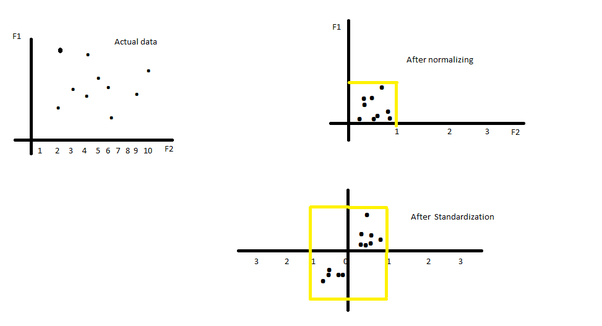

In [43]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model(To be replaced with ResNet50)
    # from keras.preprocessing import image

    if HYP_ENCODER_MODEL == "RESNET50":
        img = image.load_img(image_path, target_size=(224, 224))
    elif HYP_ENCODER_MODEL == "INCEPTIONV3":
        img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    # from keras.applications.inception_v3 import preprocess_input
    # from keras.applications.resnet50 import preprocess_input 
    x = preprocess_input(x)
    return x

In [ ]:
tmp_tst_img='/content/Flicker8k_Dataset/2450453051_f1d4a78ab4.jpg'
# preprocess(tmp_tst_img)
# image.load_img(tmp_tst_img, target_size=(224, 224))
dir(image)

###### Encoder Model Architecture

In [32]:
if HYP_ENCODER_MODEL == "RESNET50":
    model = ResNet50(weights='imagenet')

elif HYP_ENCODER_MODEL == "VGG16":
    model = VGG16(include_top=False, weights='imagenet')

    
elif HYP_ENCODER_MODEL == "INCEPTIONV3":
    model = InceptionV3(include_top=False, weights='imagenet')

else:
    print("Invalid HYP_ENCODER_MODEL")

87924736/87910968 [==============================] - 0s 0us/step


In [33]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [37]:
if HYP_ENCODER_MODEL == "RESNET50":
    # Create a new model, by removing the last layer (output layer) from the ResNet50
    model_new = Model(model.input, model.layers[-2].output)

elif HYP_ENCODER_MODEL == "VGG16":
    model_new = Model(model.input, model.layers[-1].output)
    
elif HYP_ENCODER_MODEL == "INCEPTIONV3":
    model_new = Model(model.input, model.output)

else:
    print("Invalid HYP_ENCODER_MODEL")




#What is the output of the model here
model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                         

In [38]:
len(model.layers)

311

In [39]:
len(model_new.layers)

311

In [40]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image - user defined method
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
image = preprocess(train_img[0])
image

In [44]:
encode(train_img[0])
# train_img[0]

AttributeError: ignored

###### Get feature vectors for **train images**

In [333]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

ValueError: ignored

In [ ]:
key1, val1 = list(encoding_train.items())[0]
type(encoding_train), len(encoding_train.keys())


In [ ]:
val1.shape

###### Get feature vectors for **test images**

In [ ]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

In [ ]:
test_img[0][len(images):]

In [340]:
test_img[0]

'/content/Flicker8k_Dataset/2450453051_f1d4a78ab4.jpg'

In [ ]:
images

In [ ]:
key1, val1 = list(encoding_train.items())[0]
type(encoding_train), len(encoding_train.keys()), val1.shape


##### Dump the feature vectors of train and test images into a file using pickle mechanism

In [ ]:
!mkdir "/content/sample_data/Pickle"
pkl_train_file="/content/sample_data/Pickle/encoded_train_images.pkl"
pkl_test_file = "/content/sample_data/Pickle/encoded_test_images.pkl"

In [ ]:
# Save the bottleneck train features to disk
with open(pkl_train_file, "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

In [ ]:

# Save the bottleneck test features to disk
with open(pkl_test_file, "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

#### Text Preprocessor


###### Loading the text from given dataset into workspace

In [ ]:
if HYP_SOURCE_DATA_SET == "F8K":
    filename = "/content/Flickr8k.token.txt"

elif HYP_SOURCE_DATA_SET == "F30K":
    filename = "/content/Flickr8k.token.txt"

elif HYP_SOURCE_DATA_SET == "COCO123K":
    filename = "/content/Flickr8k.token.txt"

else:
    print("Invalid HYP_SOURCE_DATA_SET")

In [ ]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text


In [ ]:

# load descriptions
doc = load_doc(filename)
print(doc[:300])

In [ ]:
# Prepare a dict of Image key and image specific descriptions

def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping


In [ ]:
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

In [ ]:
type(descriptions), list(descriptions.items())[0]

In [ ]:
list(descriptions.keys())[:5]

In [ ]:
descriptions['10815824_2997e03d76'][2]

###### Clean up the text

In [ ]:
# prepare translation table for removing punctuation
# tokenize
# convert to lower case
# remove punctuation from each token
# remove hanging 's' and 'a'
# remove tokens with numbers in them
# store as string


def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)


In [ ]:

# clean descriptions
clean_descriptions(descriptions)

In [ ]:
descriptions['10815824_2997e03d76'][2]


###### Prepare vocabulary of words

In [ ]:
# convert the loaded descriptions into a vocabulary of words - vow
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc


In [ ]:

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

In [ ]:
type(vocabulary), list(vocabulary)[:5]

###### Dump / Write all the descriptions into a file
- [image1] [description1]
- [image2] [description2]
- [image3] [description3]

In [ ]:

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

In [ ]:

save_descriptions(descriptions, 'descriptions.txt')


## Train and test data sets


#### Images

In [ ]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)


In [ ]:
# load training dataset (6K)
train = load_set(train_images_file)
print('Dataset: %d' % len(train))

In [ ]:
list(train)[:5]

In [ ]:
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [ ]:
type(img), img[:5]

In [ ]:

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [ ]:

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

#### Descriptions

In [ ]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions


In [ ]:
type(train), len(train), list(train)[:5]


In [ ]:

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

In [ ]:
train_descriptions

In [ ]:
list(train_descriptions.items())[0]

In [ ]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
    # if True:
        # break
len(all_train_captions) #, all_train_captions

In [ ]:
#To Check if there are any duplicate captions in train description. there are 232 duplicate entries
type(all_train_captions), len(all_train_captions), len(set(all_train_captions)), len(all_train_captions) - len(set(all_train_captions)) 

In [ ]:
# Prepare dataset for test dataset

###### Load all the captions and prepare 
1.   word_dict
2.   ixtoword
3.   wordtoix

In [ ]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words [Actual words] %d -> [Words which are having >= 10 threshold] %d' % (len(word_counts), len(vocab)))

In [ ]:
vocab[:5]

In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
list(wordtoix.items())[:5], list(ixtoword.items())[:5]

In [ ]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

In [ ]:
ixtoword

In [ ]:
pkl_wordtoix_file = "/content/sample_data/Pickle/wordtoix.pkl"
pkl_ixtoword_file = "/content/sample_data/Pickle/ixtoword.pkl"

In [ ]:
# Save the bottleneck train features to disk
with open(pkl_wordtoix_file, "wb") as encoded_wordtoix_pickle:
    dump(wordtoix, encoded_wordtoix_pickle)

In [ ]:
# Save the bottleneck train features to disk
with open(pkl_ixtoword_file, "wb") as encoded_ixtoword_pickle:
    dump(ixtoword, encoded_ixtoword_pickle)

###### Find max length of the word from the descriptions

In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)


In [ ]:

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

#### Download Glove data set and load the content into workspace
GloVe - is an unsupervised learning algorithm for obtaining vector representations for words.


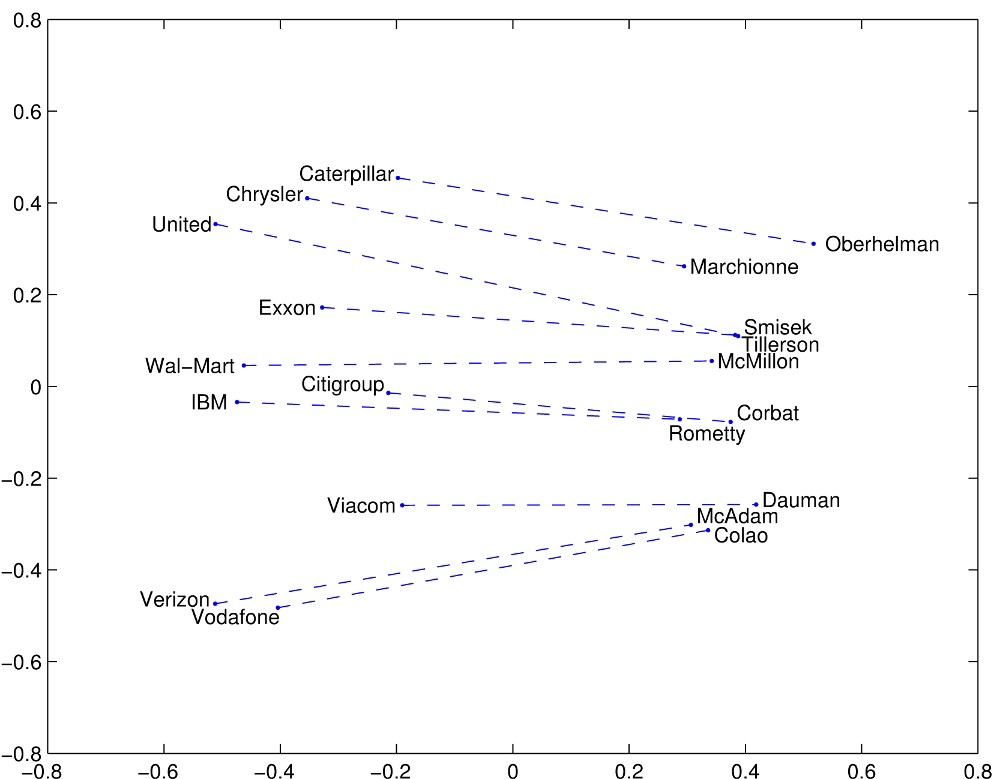

In [ ]:
if HYP_DOWNLOAD_DATASET:
    if HYP_WORD_EMBEDDING == "GLOVE":
        !wget http://nlp.stanford.edu/data/glove.6B.zip
        !unzip glove*.zip
        # !wget http://nlp.stanford.edu/data/glove.6B.200d.zip
        # !unzip glove.6B.200d.zip

    elif HYP_WORD_EMBEDDING == "WORD2VEC":
        pass

    else:
        print("Invalid HYP_WORD_EMBEDDING")

In [ ]:
if HYP_WORD_EMBEDDING == "GLOVE":
    # Load Glove vectors
    glove_dir = '/content/'
    embeddings_index = {} # empty dictionary

    f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

elif HYP_WORD_EMBEDDING == "WORD2VEC":
    pass

else:
    print("Invalid HYP_WORD_EMBEDDING")

print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
type(embeddings_index), embeddings_index['feel'].shape, embeddings_index['feel'][:10]

#### Get feature vectors for required words

In [ ]:

embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
missing_word_list = list()

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
    else:
        missing_word_list.append(word)

In [ ]:
embedding_matrix

In [ ]:
if HYP_ENABLE_TRACE:
    embedding_matrix_tmp = np.zeros((vocab_size, 10))
    print(embedding_matrix_tmp.shape)
    print(embedding_matrix_tmp[:10])

In [ ]:
missing_word_count=0
for each in embedding_matrix:
    if not all(each):
        # print(each)
        missing_word_count += 1

print("number of words missed: %s" % missing_word_count)

In [ ]:
missing_word_list

## LSTM Network


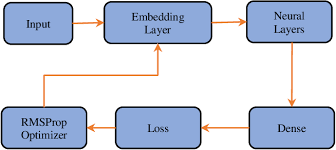

### Model architecture

###### SKIP EXECUTION - Trace - Decoder with LSTM

In [ ]:
if HYP_ENABLE_TRACE:
    tmp_inputs1 = Input(shape=(2048,)) 
    tmp_inputs1.shape, tmp_inputs1

#### model without attention


In [ ]:
if not HYP_ENABLE_ATTENTION:
    inputs1 = Input(shape=(2048,)) #2048 is the output of the RESNET50
    fe1 = Dropout(0.5)(inputs1) # Dropping off 50% from the input - 1024
    fe2 = Dense(256, activation='relu')(fe1) #relu 0 if <0.5 and 1 if >=0.5

    # [1,0,0,0,1,1,0,0,1]

    inputs2 = Input(shape=(max_length,)) #max_length = 34
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2) # embedding_dim = 200, vocab_size = 8762
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe2, se3])

    decoder2 = Dense(256, activation='relu')(decoder1)

    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    lstm_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

##### Plot with out attention

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(lstm_model, "my_first_model.png", show_shapes=True, show_dtype=True,\
#            show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96, \
#            layer_range=None, show_layer_activations=True)

#### Model with Attention


###### SKIP EXECUTION - Attention architecture - BahdanauAttention - Try-Error

In [ ]:
import tensorflow as tf

class BahdanauAttention(tf.keras.layers.Layer): # extending Layer(for building the architeccture in the form of layers) vs Model (to build a model)
  def __init__(self, units, verbose=0):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)
    self.verbose= verbose

  def call(self, query, values): 
    """
    query: features vectory
    values: hidden
    """

    if self.verbose:
      print('\n******* Bahdanau Attention STARTS******')
      print('query (decoder hidden state): (batch_size, hidden size) ', query.shape)
      print('values (encoder all hidden state): (batch_size, max_len, hidden size) ', values.shape)

    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1) # For converting (2048,) ==> (2048,1) 

    # query vs values input to the expand dims
    
    if self.verbose:
      print('query_with_time_axis:(batch_size, 1, hidden size) ', query_with_time_axis.shape)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    
    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

    #values_with_time_axis

 
    if self.verbose:
      print('score: (batch_size, max_length, 1) ',score.shape)

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    if self.verbose:
      print('attention_weights: (batch_size, max_length, 1) ',attention_weights.shape)
    # context_vector shape after sum == (batch_size, hidden_size)
    
    context_vector = attention_weights * values
    #  attention_weights * query
    
    if self.verbose:
      print('context_vector before reduce_sum: (batch_size, max_length, hidden_size) ',context_vector.shape)

    context_vector = tf.reduce_sum(context_vector, axis=1)

    if self.verbose:
      print('context_vector after reduce_sum: (batch_size, hidden_size) ',context_vector.shape)
      print('\n******* Bahdanau Attention ENDS******')
      
    return context_vector, attention_weights


###### SKIP EXECUTION - Scrap 

In [ ]:
if HYP_ENABLE_TRACE:
    #CNN_Encoder()
    inputs1 = Input(shape=(2048,)) #2048 is the output of the RESNET50
    fe1 = Dropout(0.5)(inputs1) # Dropping off 50% from the input - 1024
    fe2 = Dense(256, activation='relu')(fe1) #relu 0 if <0.5 and 1 if >=0.5

    # fe2 is features of the image from the encoder()
    # [1,0,0,0,1,1,0,0,1]

    #Attention
    #BahdanauAttention(units, verbose=0)
    # attention = BahdanauAttention(256, verbose=0)

In [ ]:
if HYP_ENABLE_TRACE:
    fe2

In [ ]:
if HYP_ENABLE_TRACE:
    embedding_dim

In [ ]:
if not HYP_ENABLE_ATTENTION:
    inputs1 = Input(shape=(2048,)) #2048 is the output of the RESNET50
    fe1 = Dropout(0.5)(inputs1) # Dropping off 50% from the input - 1024
    fe2 = Dense(256, activation='relu')(fe1) #relu 0 if <0.5 and 1 if >=0.5

    # [1,0,0,0,1,1,0,0,1]

    inputs2 = Input(shape=(max_length,)) #max_length = 34
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2) # embedding_dim = 200, vocab_size = 8762
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    #
    decoder1 = add([fe2, se3])

    decoder2 = Dense(256, activation='relu')(decoder1)

    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    lstm_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

##### Attention Architecture

build()

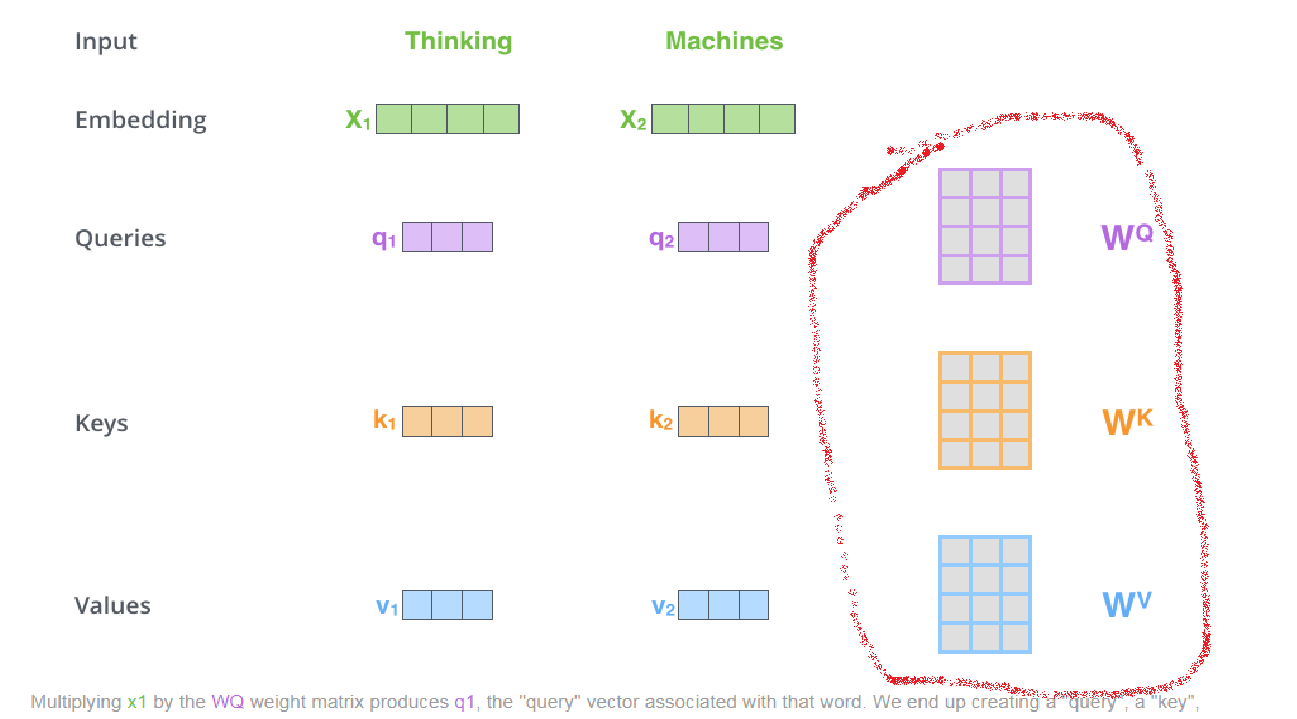

Call()

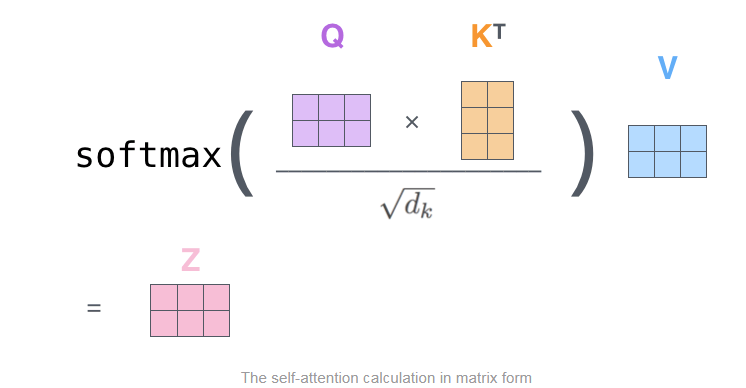

In [ ]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

##### Embedding Attention and creating a model

In [ ]:
features = 2048

vocab_size, features

In [ ]:
embedding_dim

In [ ]:
# Reference: https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/

if HYP_ENABLE_ATTENTION:

    inputs1 = Input(shape=(2048,)) #2048 is the output of the RESNET50
    fe1 = Dropout(0.5)(inputs1) # Dropping off 50% from the input - 1024
    fe2 = Dense(256, activation='relu')(fe1) #relu 0 if <0.5 and 1 if >=0.5

    inputs2 = Input(shape=(34,))
    # inputs=Input((features,))
    #embedding_dim - replace at output_dim
    # x=Embedding(input_dim=vocab_size, output_dim=200, input_length=features, embeddings_regularizer=keras.regularizers.l2(.001))(inputs1)
    x = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2) # embedding_dim = 200, vocab_size = 8762

    #se3 = LSTM(256)(se2)
    att_in=LSTM(256,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(x)

    att_out=attention()(att_in)

    decoder1 = add([fe2, att_out])

    decoder2 = Dense(256, activation='relu')(decoder1)

    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    lstm_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# outputs=Dense(1,activation='sigmoid',trainable=True)(att_out)

# model=Model(inputs1,outputs)


In [ ]:
lstm_model.summary()

##### Plot the model

In [ ]:

plot_model(lstm_model, "my_first_model.png", show_shapes=True, show_dtype=True,\
           show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96, \
           layer_range=None, show_layer_activations=True)

##### Compile model and set parameters

In [ ]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

In [ ]:
lstm_model.compile(loss=HYP_DECODER_LOSS, optimizer=HYP_DECODER_OPTIMIZER, metrics=METRICS)

In [ ]:
epochs = HYP_EPOCH
number_pics_per_bath = HYP_NO_OF_PICS_PER_BATCH
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
steps

###### SKIP EXECUTION - temp scrap

In [ ]:
if HYP_ENABLE_TRACE:
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    model.fit(x=train_x,y=train_y,batch_size=100,epochs=3,verbose=1,shuffle=True,validation_split=0.2)

In [ ]:
if HYP_ENABLE_TRACE:
    # inputs1 = Input(shape=(2048,)) #2048 is the output of the RESNET50
    # fe1 = Dropout(0.5)(inputs1) # Dropping off 50% from the input - 1024
    # fe2 = Dense(256, activation='relu')(fe1) #relu 0 if <0.5 and 1 if >=0.5

    # [1,0,0,0,1,1,0,0,1]

    units = 512
    # embedding_dim = 200 #256 # 200
    #  vocab_size = 1652

    # decoder(dec_input, features, hidden)

    inputs2 = Input(shape=(max_length,)) #max_length = 34

    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2) # embedding_dim = 200, vocab_size = 1652 # units = 512

    gru1 = tf.keras.layer.GRU(units, return_sequence=True, return_state=True, recurrent_initializer='glorot_uniform')

    fc1 = Dense(units)
    fc2 = Dense(vocab_size)

    attention = BahdanauAttention(units, verbose=1)
    
    # call(self, x=dec_input, features=fe2, hidden):
    #   dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * target.shape[0], 1)
    context_vector, attention_weights = attention(units)
    # se2 = Dropout(0.5)(se1)

    # se3 = LSTM(256)(se2)

    #decoder(dec_input, features, hidden)

In [ ]:
if HYP_ENABLE_TRACE:
    context_vector, attention_weights = attention(fe2, se3)

In [ ]:
if HYP_ENABLE_TRACE:
    attention_weights.shape, context_vector.shape, attention_weights.shape

In [ ]:
if HYP_ENABLE_TRACE:
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)

    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # create attention object = 
    outputs, inputs1, inputs2

In [ ]:
if HYP_ENABLE_TRACE:
    lstm_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # lstm_model = Model(inputs=[inputs1], outputs=outputs)

In [ ]:
if HYP_ENABLE_TRACE:
    plot_model(lstm_model, "my_first_model.png", show_shapes=True, show_dtype=True,\
               show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96, \
               layer_range=None, show_layer_activations=True)

In [ ]:
if HYP_ENABLE_TRACE:
    embedding_matrix.shape

In [ ]:
if HYP_ENABLE_TRACE:
    attention_weights

In [ ]:
if HYP_ENABLE_TRACE:
    lstm_model.layers[2].set_weights([embedding_matrix])
    lstm_model.layers[2].trainable = False

### Updating the lstm_model parameters


In [ ]:
model.layers[2]

In [ ]:
embedding_matrix.shape

In [ ]:
lstm_model.layers[2].set_weights([embedding_matrix])
lstm_model.layers[2].trainable = False

## Training the model

#### Image / Description loader in the form of batches

###### data generator

In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

###### SKIP EXECUTION - Try - Error

In [ ]:
if HYP_ENABLE_TRACE:
    arrays = [np.random.randn(3, 4) for _ in range(10)]
    arrays
    np.stack(arrays, axis=0).shape

In [ ]:
# There is an error, need to fix:
# ref: https://datascience.stackexchange.com/questions/103467/valueerror-layer-model-4-expects-1-inputs-but-it-received-10-input-tensors

In [ ]:
#train_features

In [ ]:
if HYP_ENABLE_TRACE:
    for i in range(epochs):
        generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
        model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
        model.save('./model_weights/model_' + str(i) + '.h5')

#### Fitting the lstm model without optimizer

In [ ]:
train_features = load(open(pkl_train_file, "rb"))
print('Photos: train=%d' % len(train_features))

In [ ]:
len(train_descriptions)

In [ ]:
# train_descriptions
# train_features
# wordtoix
# max_length 
# number_pics_per_bath
max_length

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    lstm_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    lstm_model.save('./model_weights/model_' + str(i) + '.h5')

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    lstm_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    lstm_model.save('./model_weights/model_' + str(i) + '.h5')

#### Fitting the lstm model with optimizer

In [ ]:
lstm_model.optimizer.lr = HYP_DECODER_LEARNING_RATE
epochs = HYP_EPOCH
number_pics_per_bath = HYP_NO_OF_PICS_PER_BATCH
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    lstm_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #lstm_model.save('./model_weights/model_' + str(i) + '.h5')

#### Saving the model weights

In [ ]:
lstm_model.save_weights('./model_weights/model_30.h5')

## Testing the model

In [ ]:
lstm_model.load_weights('./model_weights/model_30.h5')

In [ ]:
with open(pkl_test_file, "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

## Caption Geneartion

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = lstm_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

## Metrics - BLEU and METEOR

In [ ]:
def get_expected_caption(image=None):
    expected_captions = descriptions[pic[:-4]]
    expected_captions = [each.split() for each in expected_captions]
    return expected_captions
    

In [ ]:
def get_bleu_scores(image=None, caption=None):
    expected_captions = get_expected_caption(image = image)
    if None in [image, caption]:
        print("Cannot find the BLEU Score")
        return
    print("Expected captions: ", expected_captions)
    

    bleu_score_1_gram = sentence_bleu(expected_captions, caption.split(), weights=(1, 0, 0, 0))
    bleu_score_2_gram = sentence_bleu(expected_captions, caption.split(), weights=(0, 1, 0, 0))
    bleu_score_3_gram = sentence_bleu(expected_captions, caption.split(), weights=(0, 0, 1, 0))
    bleu_score_4_gram = sentence_bleu(expected_captions, caption.split(), weights=(0, 0, 0, 1))
    print('BLEU score 1 Gram -> {}'.format(bleu_score_1_gram))
    print('BLEU score 2 Gram -> {}'.format(bleu_score_2_gram))
    print('BLEU score 3 Gram -> {}'.format(bleu_score_3_gram))
    print('BLEU score 4 Gram -> {}'.format(bleu_score_4_gram))
    print("______________________________________________________________________________")
    

In [ ]:
def get_meteor_scores(image=None, caption=None):
    expected_captions = get_expected_caption(image = image)
    if None in [expected_captions, caption]:
        print("Cannot find the METEOR Score")
        return
    print("Expected captions: ", expected_captions)
    # expected_captions = [each.split() for each in expected_captions]
    
    meteor_score_1_gram = meteor_score(expected_captions, caption.split())
    print('METEOR score -> {}'.format(meteor_score_1_gram))
    print("______________________________________________________________________________")
    

## User interface

In [ ]:
# for z in range(15):
#   pic = list(encoding_test.keys())[z]
if True:
  pic = "3596131692_91b8a05606.jpg" #list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,2048))
  x=plt.imread(images+pic)
  plt.imshow(x)
  plt.show()
  caption = greedySearch(image)
  print("______________________________________________________________________________")
  print("Image: ", pic)
  print("Generated caption: ", caption)
  print("______________________________________________________________________________")

  if HYP_GENERATE_BLEU_SCORE:
    get_bleu_scores(image=pic, caption=caption)

  if HYP_GENERATE_METEOR_SCORE:
    get_meteor_scores(image=pic, caption=caption)

## Stats

In [ ]:
print("************************* Hyper Parameters *************************")
print("HYP_SOURCE_DATA_SET = ", HYP_SOURCE_DATA_SET)
print("HYP_ENCODER_MODEL = ", HYP_ENCODER_MODEL)
print("HYP_WORD_EMBEDDING = ", HYP_WORD_EMBEDDING)
print("HYP_ENABLE_TRACE = ", HYP_ENABLE_TRACE)
print("HYP_ENABLE_ATTENTION = ", HYP_ENABLE_ATTENTION)
print("HYP_DECODER_LOSS = ", HYP_DECODER_LOSS)
print("HYP_DECODER_OPTIMIZER = ", HYP_DECODER_LOSS)
print("HYP_NO_OF_PICS_PER_BATCH = ", HYP_NO_OF_PICS_PER_BATCH)
print("HYP_EPOCH = ", HYP_EPOCH)
print("HYP_DECODER_LEARNING_RATE = ", HYP_DECODER_LEARNING_RATE)
print("\n\n\n")
print("************************* Observations *************************")
print("Train Accuracy = ")
print("Test Accuracy = ")
print("Bleu Metrics = ")